## MyKNN Regressor

In [1]:
import numpy as np
import pickle

### 第一題 [myknn_regressor]

### Q1.1

手刻KNN模型，寫一個Python class，命名為myknn_regressor，給予訓練資料和hyper-parameters，對測試資料進行預測。
初始化物件時，需給定k (k個鄰居) 和 mode (模式，是equal_weight或是remove_outliers)

In [2]:
class myknn_regressor:
    
    def __init__(self, k, mode): 
        self.k = k 
        if k < 10 :  # if k<10，模式只能是equal_weight
            self.mode = "equal_weight"
        else :
            self.mode = mode
    
    def fit(self,X_train,Y_train):
        self.x_train = X_train
        self.y_train = Y_train
    
    def f(self,y_a): #給予離一筆test data最近的k個資料點y_a，根據不同模式(equal_weight or remove_outliers)，算出預測值
            
        q1 = np.percentile(self.y_train,25) #第25百分位數
        q3 = np.percentile(self.y_train,75) #第75百分位數
        iqr = q3-q1 #IQR
        lb = q1-1.5*iqr #lower bound
        ub = q3+1.5*iqr #upper bound
            
        pred = 0
        n = 0
            
        if self.mode == "remove_outliers": # 模式為remove_outliers
                
            for i in range(len(y_a)):
                if y_a[i] > ub or y_a[i] < lb: # 識別outliers,outlier不列入預測值的計算中
                    continue
                        
                pred+=y_a[i]
                n+=1
                
            pred/=n
                
        elif self.mode == "equal_weight": # 模式為equal_weight
            pred = sum(y_a)/len(y_a)
                
        return pred
        
    
    def predict(self,X_test):
        
        y_pred = []

        for t in range(len(X_test)): # 掃過每個testing data
            test = X_test[t]
            distances = []
            for i in range(len(self.x_train)): #掃過每個training data
                d= np.linalg.norm(test - self.x_train[i]) #計算歐式距離
                distances.append(d)
        
            rank = np.argsort(distances) #將training data依據距離排序
            
            y_a = self.y_train[rank[:self.k]] #選取離這筆test data最近的k個training data
            
            pred = self.f(y_a) #算出預測值
        
            y_pred.append(pred)
            
        return np.array(y_pred)

### Q1.2 
讀入資料集，資料先針對feature value進行標準化，設定KNN模型的k=20，模式為equal_weight

首先讀入資料集，觀察資料筆數以及feature個數

In [3]:
file = open('msd_data1.pickle','rb')
data = pickle.load(file)
file.close()
print("x_train:",data['X_train'].shape)
print("x_test:",data['X_test'].shape)
print("y_train:",data['Y_train'].shape)
print("y_test:",data['Y_test'].shape)

x_train: (5000, 90)
x_test: (3000, 90)
y_train: (5000,)
y_test: (3000,)


列出訓練資料的feature value(X_train)

In [4]:
print(data['X_train'])

[[  53.39967   56.67781   55.63508 ...    1.3159     2.37448    1.85999]
 [  42.83464  -33.90478   38.97704 ...    9.72827 -175.51446  -15.8389 ]
 [  49.88591   23.30563   54.79012 ...    1.94152  101.27241    8.99355]
 ...
 [  41.04397  -96.30727   56.8073  ...    3.60251  -97.24809   -5.80797]
 [  42.8676    43.36365   29.17957 ...   18.71014  208.9029   -11.08426]
 [  36.57558   29.8733    -3.08101 ...   21.0417   106.60317    3.44396]]


寫一個標準化feature value的函式

In [5]:
#標準化
def feature_scaling(data):
    mean_values = np.mean(data['X_train'],axis=0)
    std_values = np.std(data['X_train'],axis=0)

    row = data['X_train'].shape[0]
    col = data['X_train'].shape[1]

    for r in range(row):
        for c in range(col):
            data['X_train'][r][c] = (data['X_train'][r][c] - mean_values[c]) / std_values[c]

    test_r = data['X_test'].shape[0]
    for r in range(test_r):
        for c in range(col):
            data['X_test'][r][c] = (data['X_test'][r][c] - mean_values[c]) / std_values[c]
    
    return data

對資料做feature scaling

In [6]:
import copy
old_data = copy.deepcopy(data) #原本資料
new_data = feature_scaling(data) #標準化後的資料
X_train = new_data['X_train']
Y_train = new_data['Y_train']
X_test = new_data['X_test']
Y_test = new_data['Y_test']

寫一個計算RMSE的函式

In [7]:
def rmse(predictions, targets): # 計算RMSE的函式
    return np.sqrt(((predictions - targets) ** 2).mean())

用經過標準化的資料，建立myknn_regressor模型(k=20 , equal_weight)，並印出RMSE和測試資料前20筆的預測值

In [8]:
myknn = myknn_regressor(20, "equal_weight")
myknn.fit(X_train, Y_train)
ypred = myknn.predict(X_test)
error = rmse(ypred,Y_test)
print('RMSE:',error)
print('First 20 prediction :\n',ypred[:20])

RMSE: 10.25126451549596
First 20 prediction :
 [1993.35 1993.8  2000.65 1991.5  1992.8  1998.5  1988.1  1991.65 2002.25
 2003.   2000.5  1998.65 1995.55 1997.2  1995.05 1997.4  1992.15 2000.45
 2003.2  1995.75]


### Q1.3
用在Q1.2經過標準化的資料，建立myknn_regressor模型。設定模型的k=20，模式為remove_outliers，並印出RMSE和測試資料前20筆的預測值

In [9]:
myknn1 = myknn_regressor(20, "remove_outliers")
myknn1.fit(X_train, Y_train)
ypred1 = myknn1.predict(X_test)
error1 = rmse(ypred1,Y_test)
print('RMSE:',error1)
print('First 20 prediction :\n',ypred1[:20])

RMSE: 10.335042734770095
First 20 prediction :
 [2002.         1993.8        2000.65       1992.73684211 1993.73684211
 2001.38888889 1993.86666667 1998.6        2002.25       2003.
 2000.5        1998.65       2000.875      1997.2        2000.05882353
 1997.4        1999.8        2003.83333333 2003.2        1996.94736842]


從Q1.2和Q1.3的結果，可以知道模型採用"equal_weight"的RMSE(10.25126451549596)，比採用"remove_outlier"的RMSE(10.335042734770095)還要小，在k=20的情況下，模型採用"equal_weight"的預測成效會比較好

### 第二題 [Tuning the Hyper-parameter]

分成三個case。case1用經過標準化後的資料，建立sklearn.neighbors.KNeighborsRegressor模型。case2用尚未標準化的資料，建立sklearn.neighbors.KNeighborsRegressor模型。case3用經過標準化後的資料，建立myknn_regressor模型(採取remove_outliers模式)。
每個case都用k=1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200，算出RMSE，並以圖表呈現

首先import需要的套件

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

寫一個tuning KNN模型的k的函式，並用k_list存取所需要的k( k=1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200)

In [11]:
def tuning_k(use_own,data,k_list):
    rmses = []
    
    X_train = data['X_train']
    X_test = data['X_test']
    Y_train = data['Y_train']
    Y_test = data['Y_test']
    
    for i in range(len(k_list)):
        if use_own == False:
            model = KNeighborsRegressor(n_neighbors=k_list[i])
        else:
            model = myknn_regressor(k_list[i],"remove_outliers")
        
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        rms = sqrt(mean_squared_error(y_pred, Y_test))
        rmses.append(rms)
    
    return rmses

k_list =[1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200]

#### Case1
用經過標準化後的資料，建立sklearn.neighbors.KNeighborsRegressor模型

In [14]:
rmse1 = tuning_k(use_own=False,data=new_data,k_list=k_list)

#### Case2
用尚未標準化的資料，建立sklearn.neighbors.KNeighborsRegressor模型

In [15]:
rmse2 = tuning_k(use_own=False,data=old_data,k_list=k_list)

#### Case3
用經過標準化後的資料，建立myknn_regressor模型(採取remove_outliers模式)

In [17]:
rmse3 = tuning_k(use_own=True,data=new_data,k_list=k_list)

#### Result
以圖表呈現三種case在k不同的情況下，RMSE的變化。
圖表的X軸為k(hyper parameter)，Y軸為RMSE

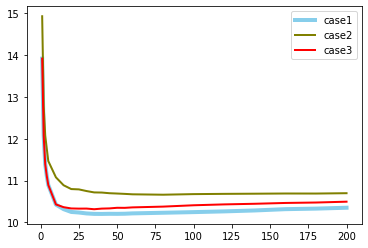

In [19]:
import matplotlib.pyplot as plt
plt.plot(k_list, rmse1, color='skyblue', linewidth=4,label="case1")
plt.plot(k_list, rmse2, color='olive', linewidth=2,label="case2")
plt.plot(k_list,rmse3, color='red',linewidth=2,label="case3")
plt.legend()
plt.show()

以RMSE作為衡量模型成效的標準來看，case1的表現最好，case3其次，表現最差的是case2。可見將資料進行標準化，的確有助於提升模型成效，讓RMSE降低。另外，從結果來看，移除outlier相較於沒有移除outlier來說，表現稍微差一點。